In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import holidays

C:\Users\advait\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def fetch_data(symbol, date):
    start_datetime = datetime.combine(date, datetime.min.time())
    end_datetime = start_datetime + timedelta(days=1)
    tickerData = yf.Ticker(symbol)
    intraday_data = tickerData.history(start=start_datetime.strftime('%Y-%m-%d'),
                                       end=end_datetime.strftime('%Y-%m-%d'),
                                       interval='1m')  
    if (intraday_data.empty) : return intraday_data
    market_start, market_end = "09:15", "15:30"
    intraday_data = intraday_data.between_time(market_start, market_end)

    return intraday_data #pd dataframe object

In [3]:
ticker = "ITC.NS"
start_date = '2024-05-11'
end_date = '2024-06-11'
for date in pd.date_range(start_date, end_date, freq='B'):
    # Check if the date is a public holiday in India. This is kinda redundant but meh
    if date in holidays.CountryHoliday('IND', years=date.year).keys():
        continue
    intraday_data = fetch_data(ticker, date)
prices = intraday_data['Close']
print(intraday_data)


ITC.NS: 1m data not available for startTime=1715538600 and endTime=1715625000. The requested range must be within the last 30 days.
ITC.NS: 1m data not available for startTime=1715625000 and endTime=1715711400. The requested range must be within the last 30 days.
$ITC.NS: possibly delisted; No price data found  (1m 2024-05-20 -> 2024-05-21)


$ITC.NS: possibly delisted; No price data found  (1m 2024-05-20 -> 2024-05-21)
                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-11 09:15:00+05:30  433.950012  434.850006  432.500000  434.850006   
2024-06-11 09:16:00+05:30  434.850006  436.000000  434.299988  435.850006   
2024-06-11 09:17:00+05:30  435.700012  435.899994  435.100006  435.399994   
2024-06-11 09:18:00+05:30  435.049988  435.200012  435.049988  435.200012   
2024-06-11 09:19:00+05:30  434.899994  434.899994  434.350006  434.500000   
...                               ...         ...         ...         ...   
2024-06-11 15:25:00+05:30  432.600006  432.700012  432.549988  432.700012   
2024-06-11 15:26:00+05:30  432.700012  432.700012  432.549988  432.700012   
2024-06-11 15:27:00+05:30  432.600006  432.700012  432.500000  432.700012   
2024-06-11 15:28:00+05:30  432.649994  432.700012  432.600006  432.600006 

In [4]:
def calculate_moving_averages(prices, short_window = 14, long_window = 26):
    short_ma = prices.rolling(window = short_window).mean()
    long_ma = prices.rolling(window = long_window).mean()
    macd = short_ma - long_ma
    return macd, short_ma, long_ma
    
def calculate_rsi(prices, Window):
    delta = prices.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window = Window).mean()
    avg_loss = loss.rolling(window = Window).mean()
    rs = avg_gain/avg_loss
    rsi = 100 - 100/(1 + rs)
    return rsi
def calculate_ema(prices, Window = 9):
    ema = prices.rolling(window = Window).mean()
    multiplier = 2/(Window + 1)
    for i in range (Window, len(prices)-1):
        ema.iloc[i+1] = multiplier*prices.iloc[i] + ema.iloc[i]*(1 - multiplier)
    return ema 

In [5]:
def backtest_strategy(prices, short_ma, long_ma):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['short_ma'] = short_ma
    signals['long_ma'] = long_ma
    signals['signal'] = 0
    signals['signal'][short_ma > long_ma] = 1
    signals['signal'][short_ma <= long_ma] = 0
    signals['positions'] = signals['signal'].diff()
    return signals

def plot_signals(signals):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 7))
    plt.plot(signals['price'], label='Price')
    plt.plot(signals['short_ma'], label='14-day MA')
    plt.plot(signals['long_ma'], label='26-day MA')
    plt.plot(signals[signals['positions'] == 1].index, signals['short_ma'][signals['positions'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(signals[signals['positions'] == -1].index, signals['short_ma'][signals['positions'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.legend()
    plt.show()

In [6]:
RSI = calculate_rsi(prices, 14)
intraday_data['RSI'] = RSI
MACD, short_ma, long_ma = calculate_moving_averages(prices)
print(MACD)
signal_line = calculate_ema(MACD)
print(signal_line)

Datetime
2024-06-11 09:15:00+05:30         NaN
2024-06-11 09:16:00+05:30         NaN
2024-06-11 09:17:00+05:30         NaN
2024-06-11 09:18:00+05:30         NaN
2024-06-11 09:19:00+05:30         NaN
                               ...   
2024-06-11 15:25:00+05:30   -0.291482
2024-06-11 15:26:00+05:30   -0.294505
2024-06-11 15:27:00+05:30   -0.296153
2024-06-11 15:28:00+05:30   -0.297252
2024-06-11 15:29:00+05:30   -0.285165
Name: Close, Length: 373, dtype: float64
Datetime
2024-06-11 09:15:00+05:30   NaN
2024-06-11 09:16:00+05:30   NaN
2024-06-11 09:17:00+05:30   NaN
2024-06-11 09:18:00+05:30   NaN
2024-06-11 09:19:00+05:30   NaN
                             ..
2024-06-11 15:25:00+05:30   NaN
2024-06-11 15:26:00+05:30   NaN
2024-06-11 15:27:00+05:30   NaN
2024-06-11 15:28:00+05:30   NaN
2024-06-11 15:29:00+05:30   NaN
Name: Close, Length: 373, dtype: float64


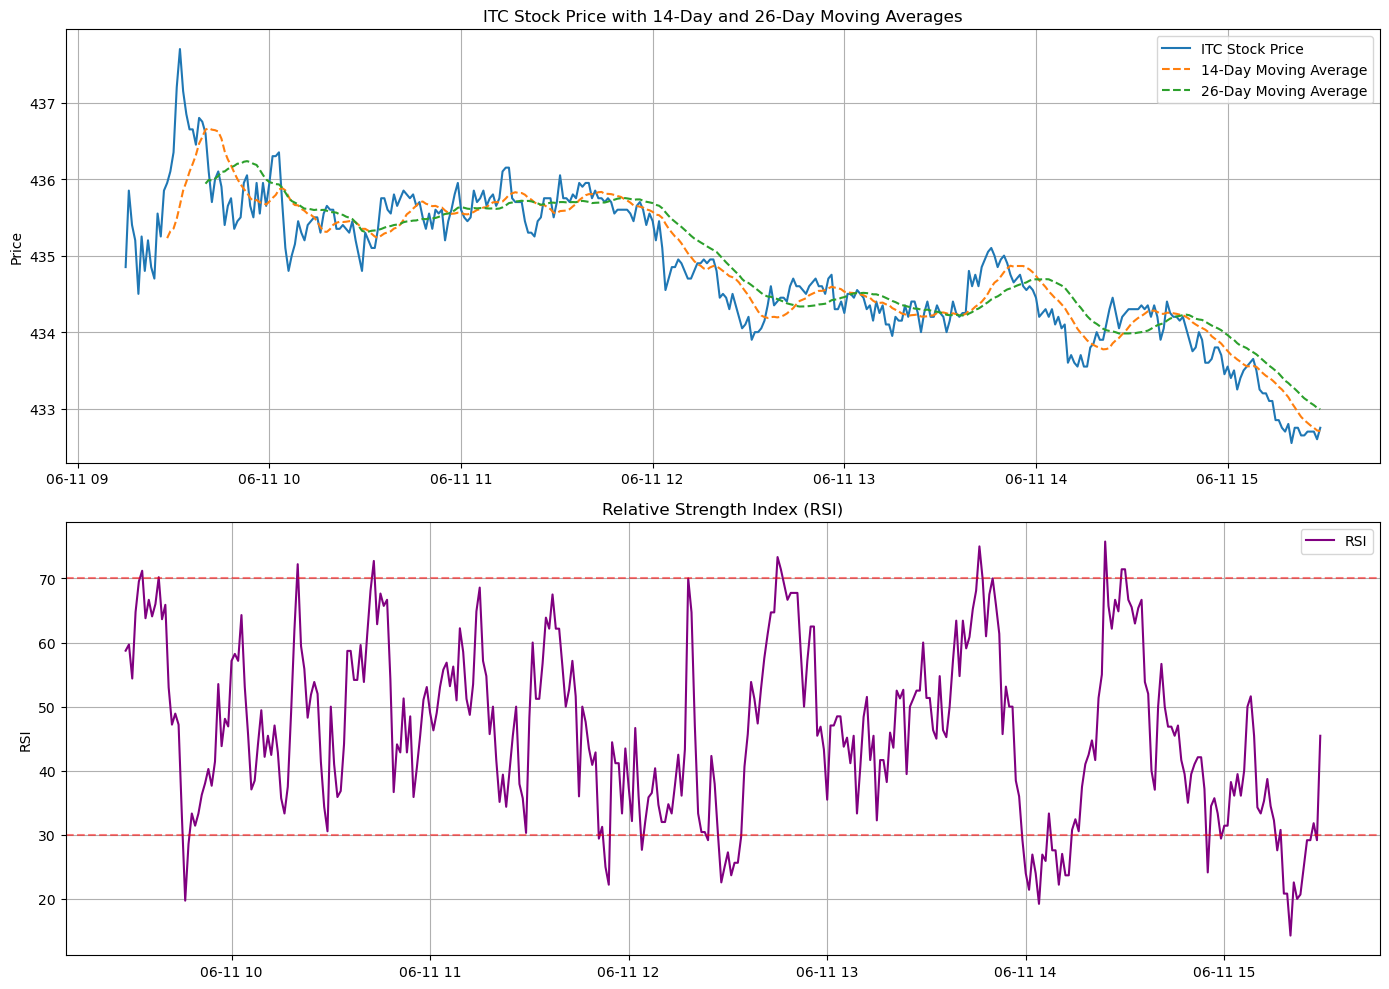

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
ax1.plot(intraday_data['Close'], label='ITC Stock Price')
ax1.plot(short_ma, label='14-Day Moving Average', linestyle='--')
ax1.plot(long_ma, label='26-Day Moving Average', linestyle='--')
ax1.set_title('ITC Stock Price with 14-Day and 26-Day Moving Averages')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid()

# Plot RSI
ax2.plot(intraday_data['RSI'], label='RSI', color='purple')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='red')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid()

# Plot MACD
plt.tight_layout()
plt.show()
     

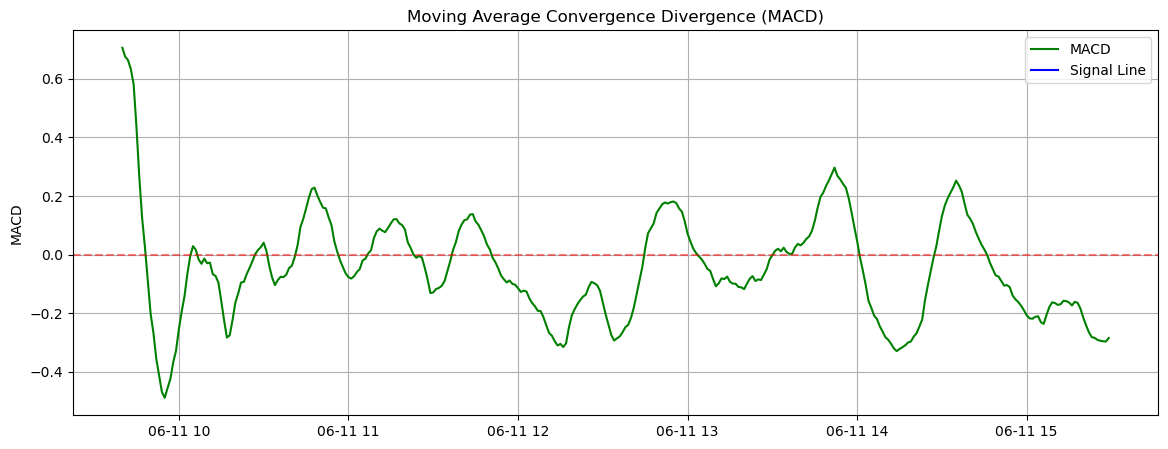

In [35]:
plt.figure(figsize =(14,5))
plt.plot(MACD, label='MACD', color='green')
plt.plot(signal_line, label='Signal Line', color='blue')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.ylabel('MACD')
plt.axhline(0, linestyle = '--', alpha = 0.5, color = 'red')
plt.legend()
plt.grid()
